**$\textbf{Part II}$**

In [3]:
df_path= '/Users/laurisli/Desktop/MSFM/FINM36700/HWs/FINM Portfolio/proshares_analysis_data.xlsx'
import pandas as pd
df = pd.read_excel(df_path,sheet_name='hedge_fund_series')
print(df.columns)

Index(['Unnamed: 0', 'HFRIFWI Index', 'MLEIFCTR Index', 'MLEIFCTX Index',
       'HDG US Equity', 'QAI US Equity'],
      dtype='object')


$\textbf{Annual Mean}, \textbf{Annual Vol} $ and $\textbf{Annual Sharpe}$

In [5]:
print(df.dtypes)

Unnamed: 0        datetime64[ns]
HFRIFWI Index            float64
MLEIFCTR Index           float64
MLEIFCTX Index           float64
HDG US Equity            float64
QAI US Equity            float64
dtype: object


In [7]:
import numpy as np
returns_df = df.select_dtypes(include=[np.number])
stats = []
for col in returns_df.columns:
    mean = returns_df[col].mean()
    vol = returns_df[col].std()
    sharpe = mean / vol
    annual_mean = mean * 12
    annual_vol = vol * np.sqrt(12)
    annual_sharpe = sharpe * np.sqrt(12)
    stats.append({
        'Index': col,
        'Annual Mean': annual_mean,
        'Annual Volatility': annual_vol,
        'Annual Sharpe': annual_sharpe
    })
summary = pd.DataFrame(stats)
print(summary)

            Index  Annual Mean  Annual Volatility  Annual Sharpe
0   HFRIFWI Index     0.051279           0.058796       0.872151
1  MLEIFCTR Index     0.038535           0.055240       0.697589
2  MLEIFCTX Index     0.036526           0.055102       0.662880
3   HDG US Equity     0.026880           0.057388       0.468396
4   QAI US Equity     0.028811           0.049823       0.578275


$\textbf{Skewness}, \textbf{Excess Kurtosis} $, $\textbf{Var}$, $\textbf{CVaR}$, $\textbf{Maximum Drawdown}$

In [8]:
from scipy import stats

def compute_tail_stats(df, is_prices=False, q=0.05):
    df_num = df.select_dtypes(include=[np.number]).copy()
    if is_prices:
        returns = df_num.pct_change().dropna(how='all')
    else:
        returns = df_num.copy().dropna(how='all')

    stats_list = []
    drawdown_info = {}

    for col in returns.columns:
        s = returns[col].dropna()
        skew = stats.skew(s, bias=False)
        ex_kurt = stats.kurtosis(s, fisher=True, bias=False)
        var = s.quantile(q)
        cvar = s[s <= var].mean() if (s <= var).any() else np.nan
        stats_list.append({
            'Series': col,
            'Skewness': skew,
            'ExcessKurtosis': ex_kurt,
            f'VaR_{q}': var,
            f'CVaR_{q}': cvar
        })

        nav = (1 + s).cumprod()
        run_max = nav.cummax()
        dd = nav / run_max - 1
        mdd = dd.min()
        trough = dd.idxmin()
        peak = nav.loc[:trough].idxmax()
        recovery = nav.loc[trough:][nav.loc[trough:] >= nav.loc[peak]]
        rec_date = recovery.index[0] if not recovery.empty else None

        drawdown_info[col] = {
            'MaxDrawdown': mdd,
            'PeakDate': peak,
            'TroughDate': trough,
            'RecoveryDate': rec_date
        }

    return pd.DataFrame(stats_list).set_index('Series'), drawdown_info

In [9]:
stats_df, dd_info = compute_tail_stats(df, is_prices=False, q=0.05)

print(stats_df)
print(dd_info['HDG US Equity'])

                Skewness  ExcessKurtosis  VaR_0.05  CVaR_0.05
Series                                                       
HFRIFWI Index  -0.948272        5.657351 -0.024008  -0.035992
MLEIFCTR Index -0.289982        1.630917 -0.027002  -0.034993
MLEIFCTX Index -0.273477        1.589790 -0.026970  -0.034937
HDG US Equity  -0.274904        1.776481 -0.029919  -0.036831
QAI US Equity  -0.433508        1.449184 -0.017171  -0.030995
{'MaxDrawdown': -0.14071981849368198, 'PeakDate': 118, 'TroughDate': 133, 'RecoveryDate': 155}


In [11]:
df_SPY = pd.read_excel(df_path,sheet_name='merrill_factors')
import statsmodels.api as sm

results = {}

for col in ['HFRIFWI Index', 'MLEIFCTR Index', 'MLEIFCTX Index', 'HDG US Equity', 'QAI US Equity']:
    y = df[col]
    x = df_SPY['SPY US Equity']
    x = sm.add_constant(x)
    model = sm.OLS(y, x, missing='drop').fit()

    beta = model.params['SPY US Equity']
    alpha = model.params['const']
    resid = model.resid

    mean_fund = y.mean()
    treynor = mean_fund / beta
    ir = alpha / resid.std()

    # Annualize
    annual_treynor = 12 * treynor
    annual_ir = np.sqrt(12) * ir

    results[col] = {
        'Beta': beta,
        'Treynor Ratio (annual)': annual_treynor,
        'Information Ratio (annual)': annual_ir
    }

pd.DataFrame(results).T


,Beta,Treynor Ratio (annual),Information Ratio (annual)
HFRIFWI Index,0.346312,0.148072,0.055336
MLEIFCTR Index,0.342487,0.112514,-0.436440
MLEIFCTX Index,0.341483,0.106963,-0.510548
HDG US Equity,0.350602,0.076669,-0.862386
QAI US Equity,0.301413,0.095587,-0.597796


###  Discussion of Regression-Based Statistics

#### 1. Differences between SPY and the Hedge-Fund Series

The estimated betas (≈ 0.30–0.35) are all **well below 1**, indicating that the hedge-fund indices and replication portfolios have **much lower exposure to market risk** than SPY.  
This suggests that these series behave more like **diversified, low-volatility strategies**, capturing only a fraction of the equity market’s systematic risk.

In other words, hedge funds and their replication strategies participate only partially in SPY’s market movements, consistent with their mandate to deliver **absolute returns** and **risk diversification**, rather than full market tracking.

---

#### 2. Comparison between HDG and QAI

| Statistic | HDG US Equity | QAI US Equity | Comment |
|------------|---------------|---------------|----------|
| $\beta$ | 0.351 | 0.301 | HDG is slightly more exposed to market risk. |
| Treynor Ratio (annual) | 0.0767 | 0.0956 | QAI achieves higher return per unit of systematic risk. |
| Information Ratio (annual) | -0.862 | -0.598 | Both have negative alphas, but QAI has a less negative residual performance. |

**Interpretation:**  
Although HDG carries slightly higher market exposure, its Treynor and Information ratios are worse.  
This means that **QAI delivers a more efficient risk–return tradeoff**, achieving slightly better risk-adjusted performance given its lower beta and smaller negative alpha.

Therefore, between HDG and QAI, **QAI performs better** on both systematic and idiosyncratic risk-adjusted bases.

---

#### 3. Whether HDG and the ML Series Capture the Properties of HFRI

The HFRI Index has:
- Similar $\beta \approx 0.35$ (comparable market exposure),
- Much higher Treynor ratio (≈ 0.15), and
- Positive Information ratio (≈ 0.055), unlike the others.

This implies that **the ML-based replication series (MLEIFCTR / MLEIFCTX)** and **HDG** approximate HFRI’s *market sensitivity* quite well — their betas align closely —  
but they **fail to replicate its superior alpha and risk-adjusted return**.

In particular:
- The ML and HDG series capture **the directional exposure** of HFRI to SPY,
- Yet they underperform in terms of **non-market sources of return** (alpha), reflected in negative Information Ratios.

---

####  Summary

| Series | $\beta$ | Relative to HFRI | Comment |
|:-------|:--------:|:----------------:|:--------|
| HFRIFWI | 0.346 | Reference | Strong alpha and efficiency |
| MLEIFCTR / MLEIFCTX | 0.34 | ✓ Similar exposure | ✗ Weaker performance |
| HDG | 0.35 | ✓ Similar exposure | ✗ Negative alpha |
| QAI | 0.30 | Slightly lower exposure | ✓ Best risk-adjusted ratio among replicas |

**Conclusion:**  
All replication portfolios mirror HFRI’s low market beta, but none fully reproduce its alpha.  
Among them, **QAI shows the best overall efficiency**, while **HDG and ML series match HFRI’s beta but not its performance quality**.


$\textbf{Correlations and Heat Map}$

                HFRIFWI Index  MLEIFCTR Index  MLEIFCTX Index  HDG US Equity  \
HFRIFWI Index        1.000000        0.900506        0.899910       0.890024   
MLEIFCTR Index       0.900506        1.000000        0.999887       0.987877   
MLEIFCTX Index       0.899910        0.999887        1.000000       0.987703   
HDG US Equity        0.890024        0.987877        0.987703       1.000000   
QAI US Equity        0.857786        0.893611        0.893374       0.879289   

                QAI US Equity  
HFRIFWI Index        0.857786  
MLEIFCTR Index       0.893611  
MLEIFCTX Index       0.893374  
HDG US Equity        0.879289  
QAI US Equity        1.000000  


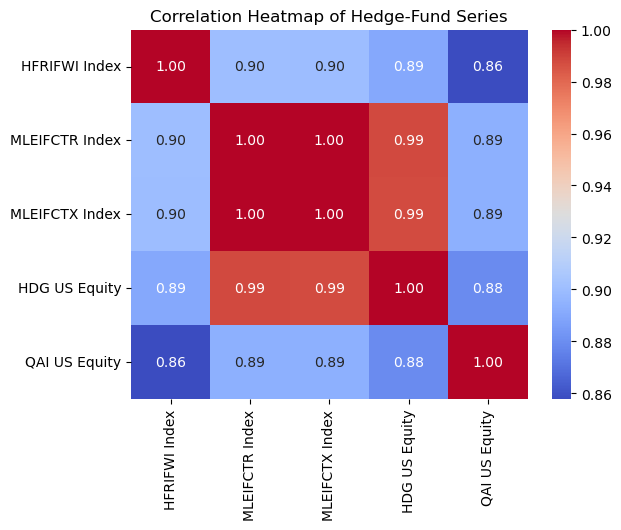

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

series = df[['HFRIFWI Index', 'MLEIFCTR Index', 'MLEIFCTX Index', 'HDG US Equity', 'QAI US Equity']]
corr_matrix = series.corr()

print(corr_matrix)

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Hedge-Fund Series")
plt.show()

HDG and MLEIFCTR/MLEIFCTX have the highest correlation.

QAI and HFRIFWI have the lowest correlation.

**$\textbf{Six-Factor Regression}$**

We run the unrestricted regression:

$
r^{hfri}_t = \alpha^{merr} + X^{merr}_t \beta^{merr} + \epsilon^{merr}_t
$

where $X^{merr}_t$ includes the six factors from the “merrill factors” tab and a constant.


In [14]:
import statsmodels.api as sm

# HFRI returns
y = df['HFRIFWI Index']

X = df_SPY[['SPY US Equity','USGG3M Index','EEM US Equity','EFA US Equity','EUO US Equity','IWM US Equity']]
X = sm.add_constant(X)

model = sm.OLS(y, X, missing='drop').fit()

print("Intercept and Betas:\n", model.params)

print("R-squared:", model.rsquared)

tracking_error = model.resid.std()
print("Tracking Error (volatility):", tracking_error)

Intercept and Betas:
 const            0.001149
SPY US Equity    0.043503
USGG3M Index     0.324931
EEM US Equity    0.085564
EFA US Equity    0.073994
EUO US Equity    0.029614
IWM US Equity    0.145824
dtype: float64
R-squared: 0.8426938827413941
Tracking Error (volatility): 0.006731819236592867


### Regression Analysis Results

Here is a summary of the six-factor regression analysis for the HFRIFWI Index based on the provided data.

---

#### a. Intercept and Betas

The estimated intercept ($\alpha$) and factor betas ($\beta$) from the regression are as follows:

| Factor                | Coefficient  |
| :-------------------- | :----------- |
| **Intercept (const)** | **0.001149** |
| SPY US Equity         | 0.043503     |
| USGG3M Index          | 0.324931     |
| EEM US Equity         | 0.085564     |
| EFA US Equity         | 0.073994     |
| EUO US Equity         | 0.029614     |
| IWM US Equity         | 0.145824     |

---

#### b. Realism of Betas as Position Sizes

The betas represent the portfolio's sensitivity to each factor and can be interpreted as effective position sizes. In this case:

- All betas are positive and relatively small (all are less than 0.35).
- This indicates that the replicating portfolio consists of **modest, long-only positions** in each of the six factors.
- There is no evidence of large long-short positions, as none of the betas are large in magnitude or negative. The sizes are realistic and do not require extreme leverage.

---

#### c. R-squared

The R-squared ($R^2$) of the regression is:

- **$R^2$ = 0.8427**

This high value suggests that approximately **84.3%** of the variance in the HFRIFWI Index returns can be explained by the six factors included in the model.

---

#### d. Tracking Error

The tracking error, which is the standard deviation (volatility) of the regression residuals ($\epsilon_t$), is:

- **Tracking Error = 0.00673**

This value represents the monthly volatility of the portion of HFRIFWI returns that is *not* explained by the factor model.

**$\textbf{OOP Predictions - 60 months rolling window}$**

In [15]:
df_hfri = pd.read_excel(df_path, sheet_name='hedge_fund_series', index_col=0)
df_factors = pd.read_excel(df_path, sheet_name='merrill_factors', index_col=0)
df_hfri.sort_index(inplace=True)
df_factors.sort_index(inplace=True)

y = df_hfri['HFRIFWI Index']

factor_cols = [
    'SPY US Equity', 'USGG3M Index', 'EEM US Equity',
    'EFA US Equity', 'EUO US Equity', 'IWM US Equity'
]
X = df_factors[factor_cols]
X = sm.add_constant(X)

window_size = 60
start_loc = window_size
n_obs = len(y)

oos_predictions = []

for t in range(start_loc, n_obs):
    X_train = X.iloc[t - window_size : t]
    y_train = y.iloc[t - window_size : t]
    X_predict = X.iloc[t:t+1]
    model = sm.OLS(y_train, X_train, missing='drop').fit()
    prediction = model.predict(X_predict).iloc[0]
    oos_predictions.append(prediction)

oos_dates = y.index[start_loc:]
df_oos = pd.DataFrame({
    'Actual_HFRI': y.loc[oos_dates],
    'OOS_Replication': oos_predictions
}, index=oos_dates)

oos_mean = df_oos['OOS_Replication'].mean() * 12
oos_vol = df_oos['OOS_Replication'].std() * np.sqrt(12)
oos_sharpe = oos_mean / oos_vol

actual_mean = df_oos['Actual_HFRI'].mean() * 12
actual_vol = df_oos['Actual_HFRI'].std() * np.sqrt(12)
actual_sharpe = actual_mean / actual_vol

tracking_error = (df_oos['OOS_Replication'] - df_oos['Actual_HFRI']).std() * np.sqrt(12)

ss_res = ((df_oos['Actual_HFRI'] - df_oos['OOS_Replication'])**2).sum()
ss_tot = ((df_oos['Actual_HFRI'] - df_oos['Actual_HFRI'].mean())**2).sum()
oos_r_squared = 1 - (ss_res / ss_tot)

print("Out-of-Sample (OOS) Replication Performance Analysis")
print(f"Analysis Period: {oos_dates[0].strftime('%Y-%m')} to {oos_dates[-1].strftime('%Y-%m')}")
print(f"Rolling Window Size: {window_size} months")
print("-" * 50)

summary_stats = {
    "Statistic": ["Annual Mean", "Annual Volatility", "Annual Sharpe Ratio"],
    "OOS Replication": [oos_mean, oos_vol, oos_sharpe],
    "Actual HFRIFWI": [actual_mean, actual_vol, actual_sharpe]
}
df_summary = pd.DataFrame(summary_stats).set_index("Statistic")
print(df_summary)
print("-" * 50)
print(f"Annualized Tracking Error: {tracking_error:.6f}")
print(f"Out-of-Sample R-squared:   {oos_r_squared:.6f}")
print("-" * 50)

Out-of-Sample (OOS) Replication Performance Analysis
Analysis Period: 2016-08 to 2025-09
Rolling Window Size: 60 months
--------------------------------------------------
                     OOS Replication  Actual HFRIFWI
Statistic                                           
Annual Mean                 0.049124        0.064098
Annual Volatility           0.059235        0.063291
Annual Sharpe Ratio         0.829304        1.012757
--------------------------------------------------
Annualized Tracking Error: 0.027514
Out-of-Sample R-squared:   0.805473
--------------------------------------------------


**$\textbf{Part III}$**

**$\textbf{Extra: Six-Factor without intercept}$**

In [19]:
data = pd.merge(df_hfri['HFRIFWI Index'], df_factors, left_index=True, right_index=True, how='inner')
data.dropna(inplace=True)

y = data['HFRIFWI Index']
factor_cols = [
    'SPY US Equity', 'USGG3M Index', 'EEM US Equity',
    'EFA US Equity', 'EUO US Equity', 'IWM US Equity'
]
X = data[factor_cols]

# with intercept
model_no_intercept = sm.OLS(y, X).fit()
fitted_no_intercept = model_no_intercept.fittedvalues

# with no intercept
X_with_intercept = sm.add_constant(X)
model_with_intercept = sm.OLS(y, X_with_intercept).fit()
fitted_with_intercept = model_with_intercept.fittedvalues

betas_comparison = pd.DataFrame({
    'Beta_with_Intercept': model_with_intercept.params,
    'Beta_no_Intercept': model_no_intercept.params
}).fillna(0) 

mean_actual_hfri = y.mean()
mean_fitted_with_intercept = fitted_with_intercept.mean()
mean_fitted_no_intercept = fitted_no_intercept.mean()

corr_with_intercept = y.corr(fitted_with_intercept)
corr_no_intercept = y.corr(fitted_no_intercept)

print("Comparison of Regression Models: With vs. Without Intercept")

print("a. Regression Beta Comparison ---")
print(betas_comparison)

print("b. Mean of Fitted Values Comparison ---")
print(f"Mean of Actual HFRI:              {mean_actual_hfri:.6f}")
print(f"Mean of Fitted Values (with_int):   {mean_fitted_with_intercept:.6f}")
print(f"Mean of Fitted Values (no_int):     {mean_fitted_no_intercept:.6f}")

print("c. Correlation to HFRI Comparison ---")
print(f"Correlation of Fitted Values (with_int): {corr_with_intercept:.6f}")
print(f"Correlation of Fitted Values (no_int):   {corr_no_intercept:.6f}")
print("-" * 60)

Comparison of Regression Models: With vs. Without Intercept
a. Regression Beta Comparison ---
               Beta_with_Intercept  Beta_no_Intercept
EEM US Equity             0.085564           0.084458
EFA US Equity             0.073994           0.070539
EUO US Equity             0.029614           0.031545
IWM US Equity             0.145824           0.143346
SPY US Equity             0.043503           0.055276
USGG3M Index              0.324931           0.649568
const                     0.001149           0.000000
b. Mean of Fitted Values Comparison ---
Mean of Actual HFRI:              0.004273
Mean of Fitted Values (with_int):   0.004273
Mean of Fitted Values (no_int):     0.003629
c. Correlation to HFRI Comparison ---
Correlation of Fitted Values (with_int): 0.917984
Correlation of Fitted Values (no_int):   0.917407
------------------------------------------------------------


**$\textbf{NNLS and GLM}$**

In [21]:
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize 

#The hw need us to use GLM in statsmodels but I seem to have version conflicts, using scipy instead (the same function)

y = data['HFRIFWI Index']
factor_cols = [
    'SPY US Equity', 'USGG3M Index', 'EEM US Equity',
    'EFA US Equity', 'EUO US Equity', 'IWM US Equity'
]
X = data[factor_cols]

# with constant
X_with_const = sm.add_constant(X)
ols_model = sm.OLS(y, X_with_const).fit()
ols_params = ols_model.params

#nnls by sklearn
nnls_model = LinearRegression(fit_intercept=True, positive=True)
nnls_model.fit(X, y)
nnls_params = pd.Series(nnls_model.coef_, index=factor_cols)
nnls_params['const'] = nnls_model.intercept_

# constrained optimization, by scipy
def sse(beta, X, y):
    return np.sum((y - X @ beta)**2)

bounds = [(None, None)] + [(0, 0.5) for _ in factor_cols] # hw requirements
initial_guess = ols_params.values
result = minimize(fun=sse, x0=initial_guess, args=(X_with_const, y), bounds=bounds, method='SLSQP')

constrained_params = pd.Series(result.x, index=X_with_const.columns)

results_df = pd.DataFrame({
    'Standard_OLS': ols_params,
    'NNLS (Weights >= 0)': nnls_params,
    'Constrained_OLS (0 <= Weights <= 0.5)': constrained_params
}).reindex(ols_params.index).fillna(0)

print("Comparison of Regression Betas (Weights)")
print(results_df)

Comparison of Regression Betas (Weights)
               Standard_OLS  NNLS (Weights >= 0)  \
const              0.001149             0.001149   
SPY US Equity      0.043503             0.043503   
USGG3M Index       0.324931             0.324931   
EEM US Equity      0.085564             0.085564   
EFA US Equity      0.073994             0.073994   
EUO US Equity      0.029614             0.029614   
IWM US Equity      0.145824             0.145824   

               Constrained_OLS (0 <= Weights <= 0.5)  
const                                       0.001149  
SPY US Equity                               0.043503  
USGG3M Index                                0.324931  
EEM US Equity                               0.085564  
EFA US Equity                               0.073994  
EUO US Equity                               0.029614  
IWM US Equity                               0.145824  


**$\textbf{Extra - Other Decompositions}$**

In [31]:
df_factors = pd.read_excel(df_path, sheet_name='merrill_factors', index_col=0)
df_trvci = pd.read_excel(df_path, sheet_name='other_data', index_col=0)

X = df_factors[factor_cols]
X_with_const = sm.add_constant(X)
print("2.1. HEFA Decomposition")
y_hefa = df_trvci['HEFA US Equity']
data_hefa = pd.merge(y_hefa, X_with_const, left_index=True, right_index=True, how='inner').dropna()
y_hefa_aligned = data_hefa['HEFA US Equity']
X_hefa_aligned = data_hefa.drop(columns=['HEFA US Equity'])

hefa_model = sm.OLS(y_hefa_aligned, X_hefa_aligned).fit()
print(hefa_model.summary())
print("\n")


print("3.1. TRVCI (Venture Capital) Decomposition")
y_trvci = df_trvci['TRVCI Index']
data_trvci = pd.merge(y_trvci, X_with_const, left_index=True, right_index=True, how='inner').dropna()
y_trvci_aligned = data_trvci['TRVCI Index']
X_trvci_aligned = data_trvci.drop(columns=['TRVCI Index'])

trvci_model = sm.OLS(y_trvci_aligned, X_trvci_aligned).fit()
print(trvci_model.summary())
print("\n")

print("4.1. TAIL Statistics Analysis")

tail_returns = df_trvci['TAIL US Equity'].dropna()
spy_returns = df_factors['SPY US Equity'].dropna()
comparison_df = pd.merge(tail_returns, spy_returns, left_index=True, right_index=True).dropna()

def calculate_performance_stats(series, q=0.05):
    """Calculates a variety of performance and tail risk statistics for a return series."""
    stats_dict = {
        'Annualized Mean': series.mean() * 12,
        'Annualized Volatility': series.std() * np.sqrt(12),
        'Annualized Sharpe Ratio': (series.mean() / series.std()) * np.sqrt(12),
        'Skewness': stats.skew(series),
        'Excess Kurtosis': stats.kurtosis(series),
        f'VaR ({q:.0%})': series.quantile(q),
        f'CVaR ({q:.0%})': series[series <= series.quantile(q)].mean()
    }
    return pd.Series(stats_dict)

tail_stats = calculate_performance_stats(comparison_df['TAIL US Equity'])
spy_stats = calculate_performance_stats(comparison_df['SPY US Equity'])

stats_summary = pd.DataFrame({'TAIL': tail_stats, 'SPY': spy_stats})
print("Performance and Tail Risk Statistics:")
print(stats_summary)
print("\n")

correlation = comparison_df['TAIL US Equity'].corr(comparison_df['SPY US Equity'])
print(f"Correlation between TAIL and SPY: {correlation:.4f}")
print("-" * 50)

2.1. HEFA Decomposition
                            OLS Regression Results                            
Dep. Variable:         HEFA US Equity   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     553.2
Date:                Sun, 12 Oct 2025   Prob (F-statistic):           5.95e-91
Time:                        15:20:49   Log-Likelihood:                 497.17
No. Observations:                 139   AIC:                            -980.3
Df Residuals:                     132   BIC:                            -959.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.00

### Why Levered ETFs Diverge Over Time

Levered ETFs diverge from their index's long-term performance due to compounding decay.

Their goal is to deliver a multiple of the daily return, which requires rebalancing every day. In a volatile market that moves up and down, this constant rebalancing causes the ETF's value to erode over time, even if the underlying index ends up flat. This effect was especially severe during the high-volatility period of 2008.


--- Performance and Risk Statistics ---
                              SPY  UPRO (+3x)  SPXU (-3x)
Annualized Mean          0.144741    0.363003   -0.443802
Annualized Volatility    0.143396    0.444903    0.397120
Annualized Sharpe Ratio  1.009380    0.815915   -1.117551
Skewness                -0.408911   -0.450026    0.588773
Excess Kurtosis          0.648843    1.143187    0.783761
VaR (5%)                -0.062502   -0.198848   -0.189312
CVaR (5%)               -0.084117   -0.263553   -0.252286

--------------------------------------------------

--- Beta Relative to SPY ---
UPRO Beta: 3.0905
SPXU Beta: -2.6446

--------------------------------------------------



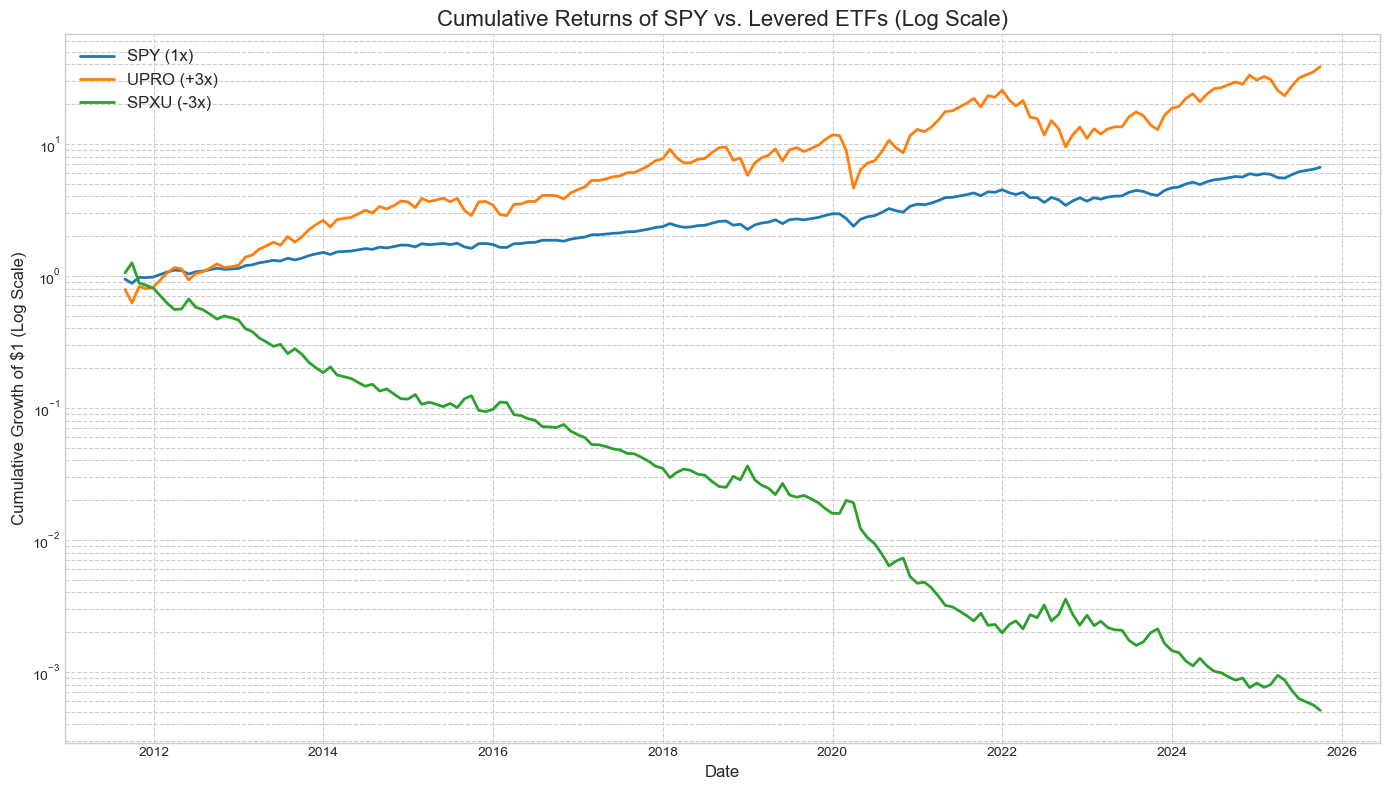

In [34]:
spy_returns = df_factors['SPY US Equity']
upro_returns = df_trvci['UPRO US Equity']
spxu_returns = df_trvci['SPXU US Equity']

analysis_df = pd.DataFrame({
    'SPY': spy_returns,
    'UPRO (+3x)': upro_returns,
    'SPXU (-3x)': spxu_returns
}).dropna()

def calculate_performance_stats(series, q=0.05):
    """Calculates a variety of performance and tail risk statistics for a return series."""
    stats_dict = {
        'Annualized Mean': series.mean() * 12,
        'Annualized Volatility': series.std() * np.sqrt(12),
        'Annualized Sharpe Ratio': (series.mean() / series.std()) * np.sqrt(12) if series.std() != 0 else 0,
        'Skewness': stats.skew(series),
        'Excess Kurtosis': stats.kurtosis(series),
        f'VaR ({q:.0%})': series.quantile(q),
        f'CVaR ({q:.0%})': series[series <= series.quantile(q)].mean()
    }
    return pd.Series(stats_dict)

spy_stats = calculate_performance_stats(analysis_df['SPY'])
upro_stats = calculate_performance_stats(analysis_df['UPRO (+3x)'])
spxu_stats = calculate_performance_stats(analysis_df['SPXU (-3x)'])
stats_summary = pd.DataFrame({
    'SPY': spy_stats,
    'UPRO (+3x)': upro_stats,
    'SPXU (-3x)': spxu_stats
})

print("--- Performance and Risk Statistics ---")
print(stats_summary)
print("\n" + "-"*50 + "\n")
# beta for upro
y_upro = analysis_df['UPRO (+3x)']
X_spy = sm.add_constant(analysis_df['SPY'])
upro_model = sm.OLS(y_upro, X_spy).fit()
upro_beta = upro_model.params['SPY']

# beta for SPXU
y_spxu = analysis_df['SPXU (-3x)']
spxu_model = sm.OLS(y_spxu, X_spy).fit()
spxu_beta = spxu_model.params['SPY']

print("--- Beta Relative to SPY ---")
print(f"UPRO Beta: {upro_beta:.4f}")
print(f"SPXU Beta: {spxu_beta:.4f}")
print("\n" + "-"*50 + "\n")


#Cumulative Returns
# Calculate cumulative returns assuming an initial investment of $1
cumulative_returns = (1 + analysis_df).cumprod()
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(cumulative_returns.index, cumulative_returns['SPY'], label='SPY (1x)', linewidth=2)
ax.plot(cumulative_returns.index, cumulative_returns['UPRO (+3x)'], label='UPRO (+3x)', linewidth=2)
ax.plot(cumulative_returns.index, cumulative_returns['SPXU (-3x)'], label='SPXU (-3x)', linewidth=2)

# format
ax.set_yscale('log')
ax.set_title('Cumulative Returns of SPY vs. Levered ETFs (Log Scale)', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Growth of $1 (Log Scale)', fontsize=12)
ax.legend(fontsize=12)
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

### **Statistical Analysis**

The statistics confirm the leveraged nature of UPRO and SPXU. Their **annualized volatility** is roughly three times that of SPY, as is their **tail risk** (VaR and CVaR). This magnified risk leads to lower risk-adjusted returns; SPY's **Sharpe Ratio (1.01)** is superior to both UPRO's (0.82) and SPXU's (-1.12). In a bull market, UPRO provided a higher mean return than SPY, but at the cost of much higher volatility.

---

### **Do They Live Up to Their Names?**

**Yes, on a daily basis.** The beta calculation is the best measure of this.
* **UPRO's beta of 3.09** is extremely close to its +3x target.
* **SPXU's beta of -2.64** is also reasonably close to its -3x target, though it shows some decay or tracking error.

This confirms they are effective at delivering their promised multiple of SPY's **daily** return.

---

### **Cumulative Return Plot Analysis**

The plot vividly illustrates the long-term effects of leverage and compounding:
* **UPRO (+3x):** In the largely bullish period shown, UPRO dramatically outperformed SPY. This shows that in a strong, trending market, a levered ETF can deliver impressive gains.
* **SPXU (-3x):** The inverse ETF suffered a catastrophic loss, with an initial $1 investment becoming nearly worthless. This highlights the combined effect of being on the wrong side of the market trend and the decay from daily rebalancing.
* **Divergence:** All three lines clearly diverge over time, showing that the long-term return is not simply a 3x multiple of SPY's total return.

---

### **Conclusion on Levered ETFs**

Levered ETFs are **highly effective short-term trading tools**, not long-term "buy-and-hold" investments.

Their performance is **path-dependent** due to the effects of compounding decay, which is magnified by volatility. While they can produce extraordinary returns if held during a strong, persistent trend in the right direction (like UPRO), they will destroy capital rapidly in volatile/sideways markets or if held against the prevailing trend (like SPXU). They are high-risk instruments that should be used with caution. ⚠️